In [21]:
#take boxes determined by marisol from kathleens biforcation data and calculate average environmental information for them
#want to calculate average SST, SSS, u^2+v^2, and var(u^2+v^2)
#recaluclate spd, dir from u,v after averaging in subset routine
import xarray as xr
import numpy as np
from math import pi
import datetime as dt
import os
from os.path import exists
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from datetime import *; from dateutil.relativedelta import *
from scipy.interpolate import make_interp_spline, BSpline
from scipy.signal import savgol_filter
import sys
import geopandas as gpd
import cartopy.crs as ccrs
from cartopy.examples.arrows import sample_data
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure

sys.path.append('./subroutines/')
from shapefile_reading import explode_polygon
from shapefile_reading import get_pices_mask


In [22]:
dir_data_oscar = 'F:/data/sat_data/oscar/L4/oscar_third_deg/'
dir_data_sss='F:/data/model_data/CMEM/global-reanalysis-phy-001-030-monthly/'
dir_data_sst = 'F:/data/sst/cmc/CMC0.2deg/v2/monthly/' 
dir_data_ccmp='F:/data/sat_data/ccmp/v02.0/'
dir_data_mld='F:/data/model_data/godas/'
dir_figs = 'F:/data/NASA_biophysical/pices/figures/'
dir_timeseries = 'F:/data/NASA_biophysical/timeseries_data/'
dir_shp = 'F:/data/NASA_biophysical/pices/shapefiles/'
#oscar - reran all monthly fies & climatology, updated through 2018, 2/1/2019
#ccmp - added RVort, from 6-hourly creating new monthly and climatology 4/2/2019 
#sst - updated all files, reprocessed monthly, climatology 2/1/2019
#sss - rerunning 2018, cal climatology 2/2/2019
#ssh - re running 2018 , cal climatology 2/2/2019
#mld - reran climatology, downloaded final 2018 file 2/1/2019

def weighted_mean_of_subset(ds,data_in,cond):
    #ds = input xarray data to have weighted mean
    #data_in = ds.data some data variable that has a nan mask applied where no data lat,lon dims
    #subset condition
    R = 6.37e6 #radius of earth in m
    # we know already that the spacing of the points is 1/4 degree latitude
    grid_dy,grid_dx = (ds.lat[0]-ds.lat[1]).data,(ds.lon[0]-ds.lon[1]).data
    dϕ = np.deg2rad(grid_dy)
    dλ = np.deg2rad(grid_dx)
    dA = R**2 * dϕ * dλ * np.cos(np.deg2rad(ds.lat)) #dA.plot()
    pixel_area = dA.where(cond)  #pixel_area.plot()
    pixel_area = pixel_area.where(np.isfinite(data_in))
    total_ocean_area = pixel_area.sum(dim=('lon', 'lat'))
    data_weighted_mean = (ds * pixel_area).sum(dim=('lon', 'lat')) / total_ocean_area
    return data_weighted_mean


def get_climatology_filename(data_type):
    if data_type=='oscar':
        filename = dir_data_oscar + 'climatology_2000_2018_monthly_data_oscar.nc'        
    if data_type=='sss' or data_type=='ssh':
        filename = dir_data_sss + 'clim/climatology_1993_2017_mercatorglorys12v1_gl12_mean.nc'
    if data_type=='sst':
        filename = dir_data_sst + 'monthly_climatology_1992_2017_120000-CMC-L4_GHRSST-SSTfnd-CMC0.2deg-GLOB-v02.0-fv02.0.nc'
    if data_type == 'ccmp':
        filename = dir_data_ccmp + 'monthly/climatology_1988_2018_CCMP_Wind_Analysis_L3.0.nc'
    if data_type == 'mld':
        filename = dir_data_mld + 'monthly_climatology_dbss_obml_1992_2018.nc'
    return filename

def get_data_filename(data_type,lyr):
    if data_type == 'oscar':
        filename = dir_data_oscar + str(lyr) + 'monthly_data_oscar.nc'
    if data_type=='sss' or data_type=='ssh':
        filename = dir_data_sss + str(lyr) + '/'+ 'year_subset_mercatorglorys12v1_gl12_mean_' + str(lyr) + '.nc'
        if lyr==2018:
            filename = 'F:/data/model_data/CMEM/global-analysis-forecast-phys_001_015/monthly/year_subset_metoffice_coupled_orca025_GL4_SAL_b2018_dm20180208.nc'
    if data_type=='sst':
        filename = dir_data_sst + str(lyr) + 'monthly_average_' + '120000-CMC-L4_GHRSST-SSTfnd-CMC0.2deg-GLOB-v02.0-fv02.0.nc'
    if data_type == 'ccmp':
        filename = dir_data_ccmp + 'monthly/CCMP_Wind_Analysis_' + str(lyr) + '_V02.0_L3.0_RSS.nc'
    if data_type == 'mld':
        filename = dir_data_mld + 'dbss_obml.' + str(lyr) + '.nc'
    return filename

def get_monthly_oscar(lyr,iclim):
    if iclim==0:
        filename = get_data_filename('oscar',lyr)
    else:
        filename = get_climatology_filename('oscar')
    print(filename)
    ds=xr.open_dataset(filename)
    ds = ds.sel(lon=slice(20.0,379.9))
    ds = ds.assign_coords(lon=(((ds.lon + 180) % 360) - 180)).sortby('lon').sortby('lat')
#    ds = ds.rename({'spd': 'data'})
#    ds = ds.mean('depth')  #get rid of depth in index
    ds['spd']=(ds.u**2+ds.v**2)**.5
    ds['dir']=np.arctan2(ds.v,ds.u)* 180./pi
  #  ds=ds.drop('year')
    ds.close()
    return ds

def get_monthly_mld(lyr,iclim):
    if iclim==0:
        filename = get_data_filename('mld',lyr)
    else:
        filename = get_climatology_filename('mld')
    print(filename)
    ds=xr.open_dataset(filename)
    ds = ds.assign_coords(lon=(((ds.lon + 180) % 360) - 180)).sortby('lon').sortby('lat')
 #   ds = ds.rename({'dbss_obml': 'data'})
    ds.close()
    return ds

def get_monthly_ccmp(lyr,iclim):
    if iclim==0:
        filename = get_data_filename('ccmp',lyr)
    else:
        filename = get_climatology_filename('ccmp')
    print(filename)
    ds=xr.open_dataset(filename)
    ds = ds.assign_coords(lon=(((ds.lon + 180) % 360) - 180)).sortby('lon').sortby('lat')
    ds['spd']=(ds.uwnd**2+ds.vwnd**2)**.5
    ds['dir']=np.arctan2(ds.vwnd,ds.uwnd)* 180./pi    
#    ds = ds.rename({'spd': 'data'})
    ds.close()
    return ds

def get_monthly_sst(lyr,iclim):
    if iclim==0:
        filename = get_data_filename('sst',lyr)
    else:
        filename = get_climatology_filename('sst')
    print(filename)
    ds=xr.open_dataset(filename)
 #   ds = ds.rename({'analysed_sst': 'data'})
    ds.close()
    return ds

def get_monthly_sss(lyr,iclim):
    if iclim==0:
        filename = get_data_filename('sss',lyr)
    else:
        filename = get_climatology_filename('sss')
    if lyr<2018:
        ds=xr.open_dataset(filename,drop_variables=['mlotst','bottomT','sithick','siconc','usi','vsi','thetao','uo','vo','zos'])
    else:
        ds=xr.open_dataset(filename,drop_variables=['zos'])
    print(filename)
#    ds = ds.rename({'so': 'data'})
    ds.close()
    return ds

def get_monthly_ssh(lyr,iclim):
    if iclim==0:
        filename = get_data_filename('sss',lyr)  #same file as sss
    else:
        filename = get_climatology_filename('sss') #same file as sss
    print(filename)
    if lyr<2018:
        ds=xr.open_dataset(filename,drop_variables=['mlotst','bottomT','sithick','siconc','usi','vsi','thetao','uo','vo','so'])
    else:
        ds=xr.open_dataset(filename,drop_variables=['so'])
   # ds = ds.rename({'zos': 'data'})
    ds.close()
    return ds



In [23]:
darray = ['oscar','mld','ccmp','sst','sss','ssh']
dir_shp = 'F:/data/NASA_biophysical/pices/shapefiles/pices/'
data_dir = 'F:/data/NASA_biophysical/pices/shapefiles/pices/'
data_fig = 'F:/data/NASA_biophysical/pices/figures/'
#read in mask file
filename = 'F:/data/NASA_biophysical/pices/shapefiles/pices/PICES_all_mask.nc'
ds_pices = xr.open_dataset(filename)
ds_pices.close()


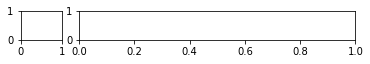

In [24]:
#just testing gridspec
grid = plt.GridSpec(6,6,wspace=0.4,hspace=0.3)
plt.subplot(grid[0,0])
plt.subplot(grid[0,1:])

In [27]:
#read in data to make time series
data_type= '_pices_data_v2.nc'
data_type2= '_pices_data_minus_clim_v2.nc'
data_type3= '_pices_data_clim_v2.nc'

dtype = 'oscar'
filename = dir_timeseries + dtype + data_type
ds_oscar = xr.open_dataset(filename)
ds_oscar.close()
filename = dir_timeseries + dtype + data_type2
ds_oscar_anom = xr.open_dataset(filename)
ds_oscar_anom.close()
filename = dir_timeseries + dtype + data_type3
ds_oscar_clim = xr.open_dataset(filename)
ds_oscar_clim.close()

dtype = 'sst'
filename = dir_timeseries + dtype + data_type
ds_sst = xr.open_dataset(filename)
ds_sst.close()
filename = dir_timeseries + dtype + data_type2
ds_sst_anom = xr.open_dataset(filename)
ds_sst_anom.close()
filename = dir_timeseries + dtype + data_type3
ds_sst_clim = xr.open_dataset(filename)
ds_sst_clim.close()

dtype = 'ccmp'
filename = dir_timeseries + dtype + data_type
ds_ccmp = xr.open_dataset(filename)
ds_ccmp.close()
filename = dir_timeseries + dtype + data_type2
ds_ccmp_anom = xr.open_dataset(filename)
ds_ccmp_anom.close()
filename = dir_timeseries + dtype + data_type3
ds_ccmp_clim = xr.open_dataset(filename)
ds_ccmp_clim.close()

dtype = 'sss'
filename = dir_timeseries + dtype + data_type
dtype, filename = 'sss', dir_timeseries + dtype + data_type
ds_sss = xr.open_dataset(filename)
ds_sss.close()
filename = dir_timeseries + dtype + data_type2
ds_sss_anom = xr.open_dataset(filename)
ds_sss_anom.close()
filename = dir_timeseries + dtype + data_type3
ds_sss_clim = xr.open_dataset(filename)
ds_sss_clim.close()

dtype = 'mld'
filename = dir_timeseries + dtype + data_type
dtype, filename = 'mld', dir_timeseries + dtype + data_type
ds_mld = xr.open_dataset(filename)
ds_mld.close()
filename = dir_timeseries + dtype + data_type2
ds_mld_anom = xr.open_dataset(filename)
ds_mld_anom.close()
filename = dir_timeseries + dtype + data_type3
ds_mld_clim = xr.open_dataset(filename)
ds_mld_clim.close()

dtype = 'ssh'
filename = dir_timeseries + dtype + data_type
dtype, filename = 'ssh', dir_timeseries + dtype + data_type
ds_ssh = xr.open_dataset(filename)
ds_ssh.close()
filename = dir_timeseries + dtype + data_type2
ds_ssh_anom = xr.open_dataset(filename)
ds_ssh_anom.close()
filename = dir_timeseries + dtype + data_type3
ds_ssh_clim = xr.open_dataset(filename)
ds_ssh_clim.close()


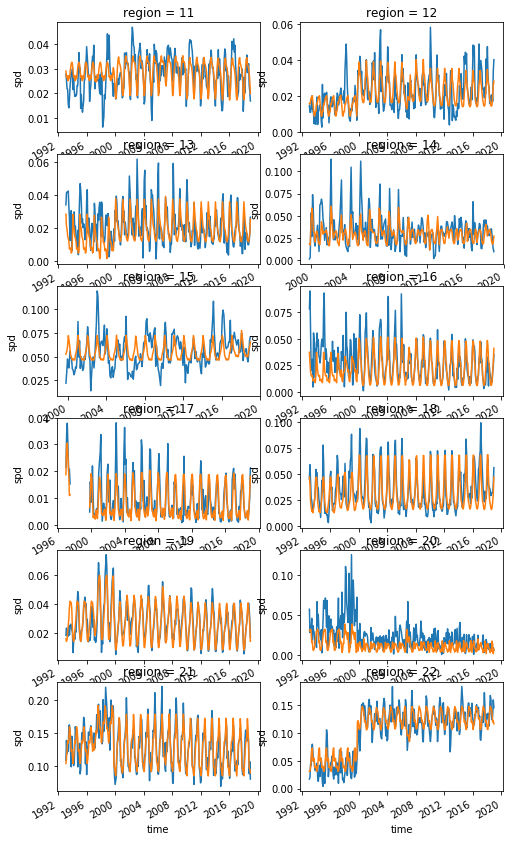

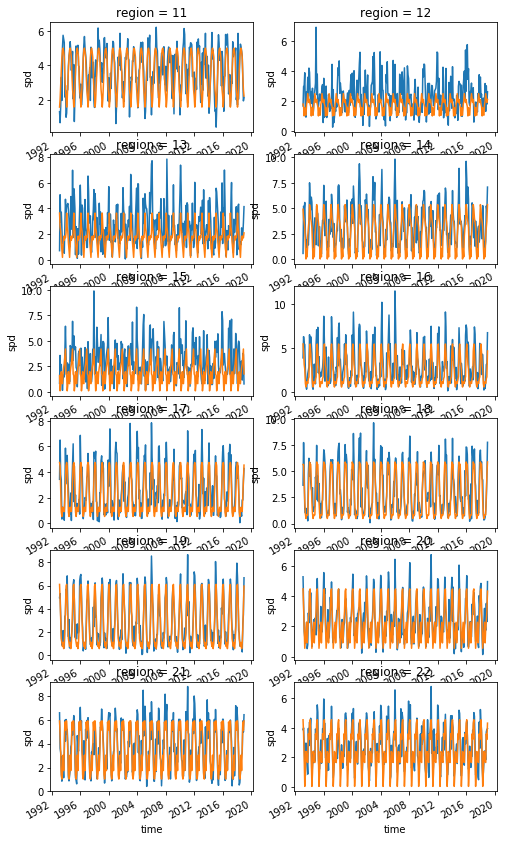

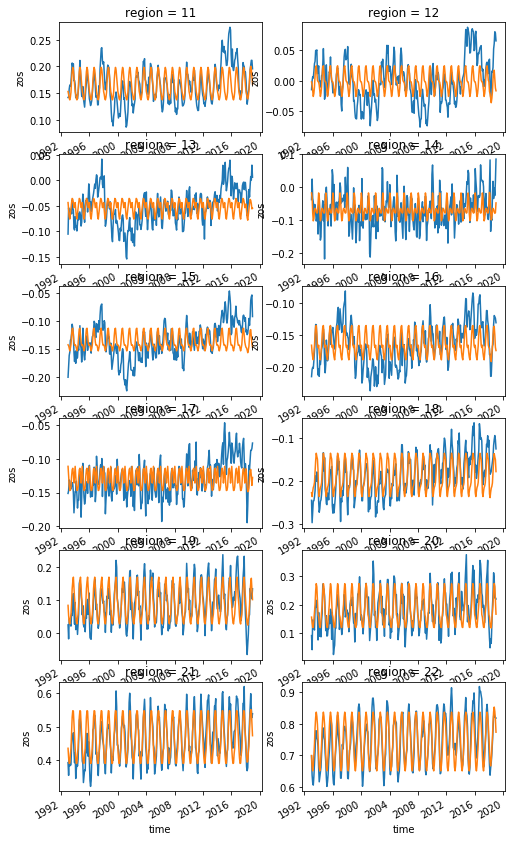

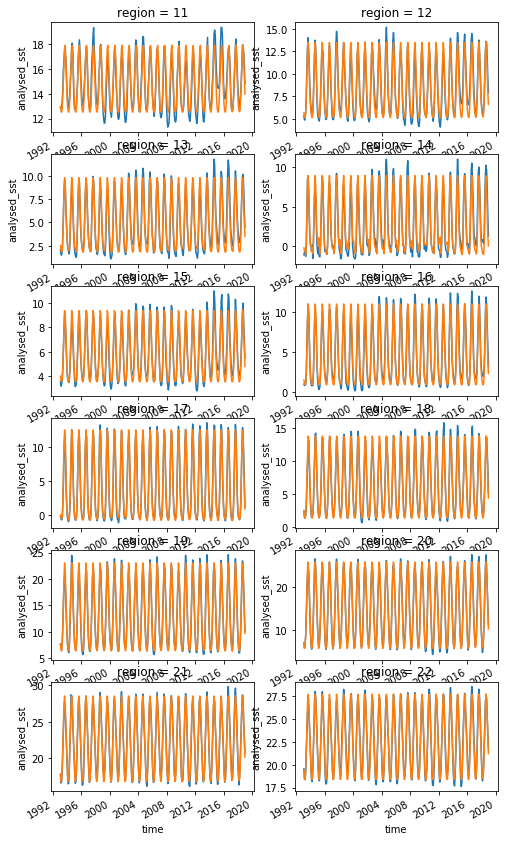

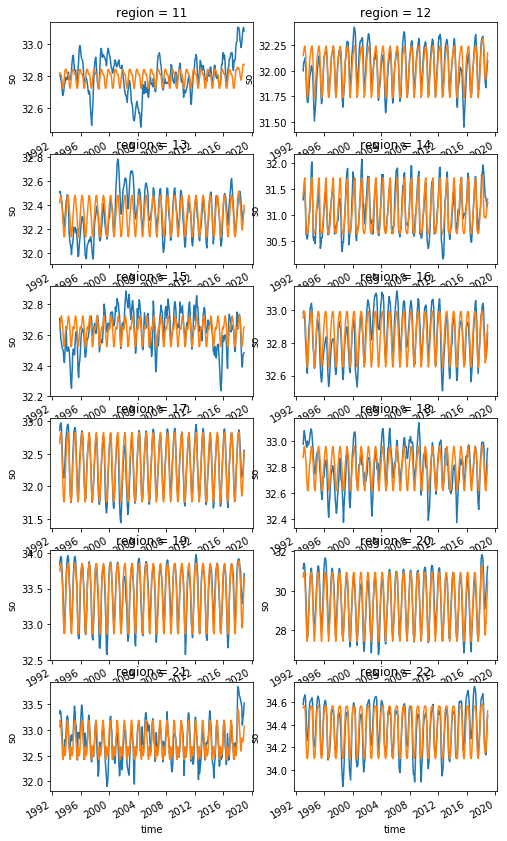

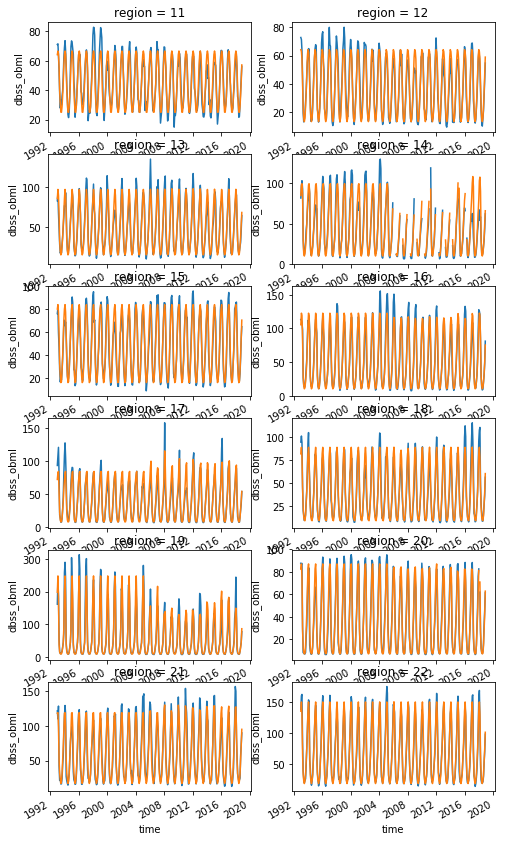

In [28]:
#for oscar, for regions with a lot of land in them, there is a distinct difference in the data before 
#2000 and after 2000.  Before 2000 the land masking removed most coastal currents and greatly reduces
#the variablity
#regions affected 12, 16, 17 (most data just gone), 
#20 (has more variability), 21 (ugh), 22 (horrid step function)
for iob in range(0,6):
    f = plt.figure(figsize=(8,19))
    if iob==0:
        sob,ds,ds2 = 'oscar',ds_oscar.spd,ds_oscar_clim.spd
    if iob==1:
        sob,ds,ds2 = 'ccmp',ds_ccmp.spd,ds_ccmp_clim.spd
    if iob==2:
        sob,ds,ds2 = 'ssh',ds_ssh.zos,ds_ssh_clim.zos
    if iob==3:
        sob,ds,ds2 = 'sst',ds_sst.analysed_sst-273.15,ds_sst_clim.analysed_sst-273.15
    if iob==4:
        sob,ds,ds2 = 'sss',ds_sss.so,ds_sss_clim.so
    if iob==5:
        sob,ds,ds2 = 'mld',ds_mld.dbss_obml,ds_mld_clim.dbss_obml
    for itype in range(11,23):
        inumfig = 821+itype-11
        #print(9,2,itype-11) #inumfig)
        ax = plt.subplot(8,2,itype-10) #inumfig)
        ds.sel(region=itype).plot()
        ds2.sel(region=itype).plot()
#            ds_ccmp.sel(region=itype).spd.plot()
#            ds_ssh.sel(region=itype).zos.plot()
#            (ds_sst.sel(region=itype).analysed_sst-273.15).plot()
#            ds_sss.sel(region=itype).so.plot()
#            ds_mld.sel(region=itype).dbss_obml.plot()
        f.savefig(dir_figs + '_pices_'+sob+'_timeseries.png', dpi=100)


In [30]:
#combine images with timeseries plots
#ds = get_monthly_sst(lyr,0)
#land_mask = ds.copy(deep=True)        
#ds = get_monthly_ccmp(lyr,0)
#land_mask2 = land_mask.interp_like(ds,method='nearest')

#read in mask file
filename = 'F:/data/NASA_biophysical/pices/shapefiles/pices/PICES_all_mask.nc'
ds_mask = xr.open_dataset(filename)
ds_mask.close()

#plot region sst map
#read in climatology sst
#for iregion in range(11,25):

for iregion in range(11,12): #25):
    lyr=2018
   # plt.figure(figsize=(13,6.2))
    #fig, axarr = plt.subplots(5,figsize=(10,14))
    f = plt.figure(figsize=(9,13))
    grid = plt.GridSpec(6,6,wspace=0.4,hspace=0.3)
    for itype in range(0,6):
        if itype == 0:
            ds = get_monthly_ccmp(lyr,0)
            ds2 = get_monthly_ccmp(lyr,1)
            ds2=xr.Dataset(data_vars={'vwnd': (('time','lat','lon'),ds2.vwnd),
                                      'uwnd': (('time','lat','lon'),ds2.uwnd),
                                      'spd': (('time','lat','lon'),ds2.spd),
                                      'dir': (('time','lat','lon'),ds2.dir),
                                      'rel_vorticity': (('time','lat','lon'),ds2.rel_vorticity)},
                            coords={'lat':ds2.lat,'lon':ds2.lon,'time':ds.time})
            ds2.spd.attrs = {'long_name':'Wind Spd (ms$^{-1}$)'}
            data_in = ds2.spd.mean('time',keep_attrs=True)
        if itype == 1:
            ds = get_monthly_sss(lyr,0)
            ds2 = get_monthly_sss(lyr,1)
            ds2=ds2.drop('depth') #0.49m
            ds2=xr.Dataset(data_vars={'so': (('time','lat','lon'),ds2.so),},
                            coords={'lat':ds2.lat,'lon':ds2.lon,'time':ds.time})
            ds2.so.attrs = {'long_name':'Sal. (psu)'}
            data_in = ds2.so.mean('time',keep_attrs=True)
        if itype == 2:
            ds = get_monthly_ssh(lyr,0)
            ds2 = get_monthly_ssh(lyr,1)
            ds2=ds2.drop('depth') #0.49m
            ds2=xr.Dataset(data_vars={'zos': (('time','lat','lon'),ds2.zos),},
                            coords={'lat':ds2.lat,'lon':ds2.lon,'time':ds.time})
            ds2.zos.attrs = {'long_name':'SSH (m)'}
            data_in = ds2.zos.mean('time',keep_attrs=True)
        if itype == 3:
            ds = get_monthly_mld(lyr,0)
            ds2 = get_monthly_mld(lyr,1)
            ds2=xr.Dataset(data_vars={'dbss_obml': (('time','lat','lon'),ds2.dbss_obml),},
                            coords={'lat':ds2.lat,'lon':ds2.lon,'time':ds.time})
            ds2.dbss_obml.attrs = {'long_name':'MLD (m)'}
            data_in = ds2.dbss_obml.mean('time',keep_attrs=True)
        if itype == 4:
            ds = get_monthly_sst(lyr,0)
            ds2 = get_monthly_sst(lyr,1)
            ds2=xr.Dataset(data_vars={'analysed_sst': (('time','lat','lon'),ds2.analysed_sst),},
                            coords={'lat':ds2.lat,'lon':ds2.lon,'time':ds.time})
            ds2.analysed_sst.attrs = {'long_name':'SST (C)'}
            data_in = ds2.analysed_sst.mean('time',keep_attrs=True)
        if itype == 5:
            ds = get_monthly_oscar(lyr,0)
            ds2 = get_monthly_oscar(lyr,1)
            ds2=xr.Dataset(data_vars={'v': (('time','lat','lon'),ds2.v),
                                      'u': (('time','lat','lon'),ds2.u),
                                      'spd': (('time','lat','lon'),ds2.spd),
                                      'dir': (('time','lat','lon'),ds2.dir)},
                            coords={'lat':ds2.lat,'lon':ds2.lon,'time':ds.time})
            ds2.spd.attrs = {'long_name':'Curr. Vel. (cm/s)'}
            data_in = ds2.spd.mean('time',keep_attrs=True)
        
        mask_interp = ds_mask.interp_like(data_in,method='nearest')
        cond = (mask_interp.region_mask ==iregion)
        ds_mean = data_in.where(cond)
        #read in world map
        if itype==0:
            latmin=ds_mean.where(np.isfinite(ds_mean),drop=True).lat.min()-2
            latmax=ds_mean.where(np.isfinite(ds_mean),drop=True).lat.max()+2
            lonmin=ds_mean.where(np.isfinite(ds_mean),drop=True).lon.min()-2
            lonmax=ds_mean.where(np.isfinite(ds_mean),drop=True).lon.max()+2
            if ((iregion>=13) & (iregion<=15)):
                lonmax=ds_mean[:,900:].where(np.isfinite(ds_mean[:,900:]),drop=True).lon.min()-2
                lonmin=ds_mean[:,:900].where(np.isfinite(ds_mean[:,:900]),drop=True).lon.max()+2
        #plt.subplot(651)
#        inumfig = 861+itype
        ax = plt.subplot(grid[itype,0], projection=ccrs.Mercator(central_longitude=180,min_latitude=20, max_latitude=70))
#plt.subplot(grid[0,1:])
#        ax = plt.subplot(inumfig, projection=ccrs.Mercator(central_longitude=180,min_latitude=20, max_latitude=70))
        ax.background_img(name='ne_shaded', resolution='low')
        #ax.background_img(name='BM', resolution='high')
        ax.set_extent([lonmax,lonmin,latmin,latmax])
        if itype!=1:
            mm = ax.pcolormesh(ds_mean.lon,ds_mean.lat,ds_mean, transform=ccrs.PlateCarree(),cmap='jet' )
        else:
            smn,ssd = ds_mean.mean(), ds_mean.std()
            mm = ax.pcolormesh(ds_mean.lon,ds_mean.lat,ds_mean,vmin=smn-ssd,vmax=smn+ssd,transform=ccrs.PlateCarree(),cmap='jet' )            
        ax.coastlines(resolution='10m');
        plt.colorbar(mm,ax=ax,shrink=.95,pad=.01,orientation="vertical",label=data_in.long_name)
        if itype==2:
            plt.title('PICES region '+str(iregion))

    for icol in range(0,6):
        ax = plt.subplot(grid[icol,1:])
        if icol==0:
            ds = ds_ccmp_clim
            tem = ds.sel(region=iregion)
            ds_smoothed = savgol_filter(tem.spd, 11, 2)
 #           ax = plt.subplot(812)
            ax.plot(ds.time[:],tem.spd, label = 'Anomaly',color='red',linewidth=1)
            ax.plot(ds.time[:],ds_smoothed, label = 'Smoothed',color='black',linewidth=2)
            ax.axhline(y=0.0, color='blue', linestyle='-')
            ax.set_ylabel('$\Delta$Wind Spd (ms$^{-1}$)')
            ax.set_ylim(-4,4)
            ax.set_xticklabels('')
            continue
        if icol==1:
            ds = ds_sss_clim
            tem = ds.sel(region=iregion)
            ds_smoothed = savgol_filter(tem.so, 11, 2)
 #           ax = plt.subplot(813)
            ax.plot(ds.time[:],tem.so, label = 'Anomaly',color='r',linewidth=1)
            ax.plot(ds.time[:],ds_smoothed, label = 'Smoothed',color='k',linewidth=2)
            ax.axhline(y=0.0, color='b', linestyle='-')
            ax.set_ylabel('$\Delta$SSS (psu)')
            ax.set_ylim(-.5,.5)
            ax.set_xticklabels('')
            continue
        if icol==2:
            ds = ds_ssh_clim
            tem = ds.sel(region=iregion)
            ds_smoothed = savgol_filter(tem.zos, 11, 2)
  #          ax = plt.subplot(814)
            ax.plot(ds.time[:],tem.zos, label = 'Anomaly',color='r',linewidth=1)
            ax.plot(ds.time[:],ds_smoothed, label = 'Smoothed',color='k',linewidth=2)
            ax.axhline(y=0.0, color='b', linestyle='-')
            ax.set_ylabel('SSH (m)')
            ax.set_ylim(-.2,.2)
            continue
        if iregion==20:
            continue
        ax.set_xticklabels('')
        if icol==3:
            ds = ds_mld_clim
            tem = ds.sel(region=iregion)
            ds_smoothed = savgol_filter(tem.dbss_obml, 11, 2)
   #         ax = plt.subplot(815)
            ax.plot(ds.time[:],tem.dbss_obml, label = 'Anomaly',color='red',linewidth=1)
            ax.plot(ds.time[:],ds_smoothed, label = 'Smoothed',color='k',linewidth=2)
            ax.axhline(y=0.0, color='b', linestyle='-')
            ax.set_ylabel('$\Delta$MLD (m)')
            ax.set_ylim(-20,20)
            ax.set_xticklabels('')
            continue
        if iregion==14:
            continue
        if icol==4:
            ds = ds_sst_clim
            tem = ds.sel(region=iregion)
            ds_smoothed = savgol_filter(tem.analysed_sst, 11, 2)
    #        ax = plt.subplot(816)
            ax.plot(ds.time[:],tem.analysed_sst, label = 'Anomaly',color='r',linewidth=1)
            ax.plot(ds.time[:],ds_smoothed, label = 'Smoothed',color='k',linewidth=2)
            ax.axhline(y=0.0, color='b', linestyle='-')
            ax.set_ylabel('$\Delta$SST (K)')
            ax.set_ylim(-3,3)
            continue
        if iregion==15:
            continue
        if iregion==17:
            continue
        ax.set_xticklabels('')
        if icol==5:
            ds = ds_oscar_clim
            tem = ds.sel(region=iregion)
            ds_smoothed = savgol_filter(tem.spd, 11, 2)
  #          ax = plt.subplot(817)
            ax.plot(ds.time,tem.spd, label = 'Anomaly',color='r',linewidth=1)
            ax.plot(ds.time,ds_smoothed, label = 'Smoothed',color='k',linewidth=2)
            ax.axhline(y=0.0, color='b', linestyle='-')
            ax.set_ylabel('$\Delta$Cur Vel (ms$^{-1}$)')
            ax.set_ylim(-0.03,0.03)
    ax.set_xlabel('Date')
    #f.autofmt_xdate()
 #   f.savefig(dir_figs + '_pices_'+str(iregion)+'image_timeseries_anomaly.png', dpi=100)

F:/data/sat_data/ccmp/v02.0/monthly/CCMP_Wind_Analysis_2018_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/monthly/climatology_1988_2018_CCMP_Wind_Analysis_L3.0.nc


C:\Users\gentemann\Miniconda3\lib\site-packages\matplotlib\axes\_base.py:3099: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=-20037508.342789244, right=-20037508.342789244
  self.set_xlim(upper, lower, auto=None)


ValueError: not enough values to unpack (expected 4, got 0)

In [32]:
ax = plt.subplot(111, projection=ccrs.Mercator(central_longitude=180,min_latitude=20, max_latitude=70))
ax.background_img(name='ne_shaded', resolution='low')
 

ValueError: not enough values to unpack (expected 4, got 0)

In [20]:
#f = plt.figure(figsize=(9,13))
grid = plt.GridSpec(6,6,wspace=0.4,hspace=0.3)
ax = plt.subplot(grid[0,0], projection=ccrs.Mercator(central_longitude=180,min_latitude=20, max_latitude=70))
#plt.subplot(grid[0,1:])
#inumfig=861
#ax = plt.subplot(inumfig, projection=ccrs.Mercator(central_longitude=180,min_latitude=20, max_latitude=70))
ax.background_img(name='ne_shaded', resolution='low')
#ax.background_img(name='BM', resolution='high')
ax.set_extent([lonmax,lonmin,latmin,latmax])
if itype!=1:
    mm = ax.pcolormesh(ds_mean.lon,ds_mean.lat,ds_mean, transform=ccrs.PlateCarree(),cmap='jet' )
else:
    smn,ssd = ds_mean.mean(), ds_mean.std()
    mm = ax.pcolormesh(ds_mean.lon,ds_mean.lat,ds_mean,vmin=smn-ssd,vmax=smn+ssd,transform=ccrs.PlateCarree(),cmap='jet' )            
ax.coastlines(resolution='10m');
plt.colorbar(mm,ax=ax,shrink=.95,pad=.01,orientation="vertical",label=data_in.long_name)
if itype==2:
    plt.title('PICES region '+str(iregion))


ValueError: not enough values to unpack (expected 4, got 0)

In [ ]:
#######copied code
#combine images with timeseries plots
ds = get_monthly_sst(lyr,0)
land_mask = ds.copy(deep=True)        
ds = get_monthly_ccmp(lyr,0)
land_mask2 = land_mask.interp_like(ds,method='nearest')

#read in mask file
filename = 'F:/data/NASA_biophysical/pices/shapefiles/pices/PICES_all_mask.nc'
ds_mask = xr.open_dataset(filename)
ds_mask.close()

#plot region sst map
#read in climatology sst
#for iregion in range(11,25):

for iregion in range(11,25):
    lyr=2018
   # plt.figure(figsize=(13,6.2))
    #fig, axarr = plt.subplots(5,figsize=(10,14))
    f = plt.figure(figsize=(9,13))
    for itype in range(0,6):
        if itype == 0:
            ds = get_monthly_ccmp(lyr,0)
            ds2 = get_monthly_ccmp(lyr,1)
            ds2=xr.Dataset(data_vars={'spd': (('time','lat','lon'),ds2.spd),
                                      'dir': (('time','lat','lon'),ds2.dir),
                                      'vwnd': (('time','lat','lon'),ds2.vwnd),
                                      'uwnd': (('time','lat','lon'),ds2.uwnd),
                                      'rel_vorticity': (('time','lat','lon'),ds2.rel_vorticity)},
                            coords={'lat':ds2.lat,'lon':ds2.lon,'time':ds.time})
            ds2.spd.attrs = {'long_name':'Wind Spd (ms$^{-1}$)'}
            data_in = ds2.spd.mean('time',keep_attrs=True)
        if itype == 1:
            ds = get_monthly_sss(lyr,0)
            ds2 = get_monthly_sss(lyr,1)
            ds2=ds2.drop('depth') #0.49m
            ds2=xr.Dataset(data_vars={'so': (('time','lat','lon'),ds2.so),},
                            coords={'lat':ds2.lat,'lon':ds2.lon,'time':ds.time})
            ds2.so.attrs = {'long_name':'Sal. (psu)'}
            data_in = ds2.so.mean('time',keep_attrs=True)
        if itype == 2:
            ds = get_monthly_ssh(lyr,0)
            ds2 = get_monthly_ssh(lyr,1)
            ds2=ds2.drop('depth') #0.49m
            ds2=xr.Dataset(data_vars={'zos': (('time','lat','lon'),ds2.zos),},
                            coords={'lat':ds2.lat,'lon':ds2.lon,'time':ds.time})
            ds2.zos.attrs = {'long_name':'SSH (m)'}
            data_in = ds2.zos.mean('time',keep_attrs=True)
        if itype == 3:
            ds = get_monthly_mld(lyr,0)
            ds2 = get_monthly_mld(lyr,1)
            ds2=xr.Dataset(data_vars={'dbss_obml': (('time','lat','lon'),ds2.dbss_obml),},
                            coords={'lat':ds2.lat,'lon':ds2.lon,'time':ds.time})
            ds2.dbss_obml.attrs = {'long_name':'MLD (m)'}
            data_in = ds2.dbss_obml.mean('time',keep_attrs=True)
        if itype == 4:
            ds = get_monthly_sst(lyr,0)
            ds2 = get_monthly_sst(lyr,1)
            ds2=xr.Dataset(data_vars={'analysed_sst': (('time','lat','lon'),ds2.analysed_sst),},
                            coords={'lat':ds2.lat,'lon':ds2.lon,'time':ds.time})
            ds2.analysed_sst.attrs = {'long_name':'SST (C)'}
            data_in = ds2.analysed_sst.mean('time',keep_attrs=True)
        if itype == 5:
            ds = get_monthly_oscar(lyr,0)
            ds2 = get_monthly_oscar(lyr,1)
            ds2=xr.Dataset(data_vars={'spd': (('time','lat','lon'),ds2.spd),
                                      'dir': (('time','lat','lon'),ds2.dir),
                                      'v': (('time','lat','lon'),ds2.v),
                                      'u': (('time','lat','lon'),ds2.u)},
                            coords={'lat':ds2.lat,'lon':ds2.lon,'time':ds.time})
            ds2.spd.attrs = {'long_name':'Curr. Vel. (cm/s)'}
            data_in = ds2.spd.mean('time',keep_attrs=True)
        
        mask_interp = ds_mask.interp_like(data_in,method='nearest')
        cond = (mask_interp.region_mask ==iregion)
        ds_mean = data_in.where(cond)
        #read in world map
        if itype==0:
            latmin=ds_mean.where(np.isfinite(ds_mean),drop=True).lat.min()-2
            latmax=ds_mean.where(np.isfinite(ds_mean),drop=True).lat.max()+2
            lonmin=ds_mean.where(np.isfinite(ds_mean),drop=True).lon.min()-2
            lonmax=ds_mean.where(np.isfinite(ds_mean),drop=True).lon.max()+2
            if ((iregion>=13) & (iregion<=15)):
                lonmax=ds_mean[:,900:].where(np.isfinite(ds_mean[:,900:]),drop=True).lon.min()-2
                lonmin=ds_mean[:,:900].where(np.isfinite(ds_mean[:,:900]),drop=True).lon.max()+2
        #plt.subplot(651)
        inumfig = 861+itype
        ax = plt.subplot(inumfig, projection=ccrs.Mercator(central_longitude=180,min_latitude=20, max_latitude=70))
        #ax.background_img(name='ne_shaded', resolution='low')
        ax.background_img(name='BM', resolution='high')
        ax.set_extent([lonmax,lonmin,latmin,latmax])
        if itype!=1:
            mm = ax.pcolormesh(ds_mean.lon,ds_mean.lat,ds_mean, transform=ccrs.PlateCarree(),cmap='jet' )
        else:
            smn,ssd = ds_mean.mean(), ds_mean.std()
            mm = ax.pcolormesh(ds_mean.lon,ds_mean.lat,ds_mean,vmin=smn-ssd,vmax=smn+ssd,transform=ccrs.PlateCarree(),cmap='jet' )            
        ax.coastlines(resolution='10m');
        plt.colorbar(mm,ax=ax,shrink=.95,pad=.01,orientation="vertical",label=data_in.long_name)
        if itype==2:
            plt.title('PICES region '+str(iregion))

    for icol in range(0,6):
        if icol==0:
            ds = ds_ccmp_clim
            tem = ds.sel(region=iregion)
            ds_smoothed = savgol_filter(tem.spd, 11, 2)
            ax = plt.subplot(812)
            ax.plot(ds.time[:],tem.spd, label = 'Anomaly',color='red',linewidth=1)
            ax.plot(ds.time[:],ds_smoothed, label = 'Smoothed',color='black',linewidth=2)
            ax.axhline(y=0.0, color='blue', linestyle='-')
            ax.set_ylabel('$\Delta$Wind Spd (ms$^{-1}$)')
            ax.set_ylim(-4,4)
            ax.set_xticklabels('')
            continue
        if icol==1:
            ds = ds_sss_clim
            tem = ds.sel(region=iregion)
            ds_smoothed = savgol_filter(tem.so, 11, 2)
            ax = plt.subplot(813)
            ax.plot(ds.time[:],tem.so, label = 'Anomaly',color='r',linewidth=1)
            ax.plot(ds.time[:],ds_smoothed, label = 'Smoothed',color='k',linewidth=2)
            ax.axhline(y=0.0, color='b', linestyle='-')
            ax.set_ylabel('$\Delta$SSS (psu)')
            ax.set_ylim(-.5,.5)
            ax.set_xticklabels('')
            continue
        if icol==2:
            ds = ds_ssh_clim
            tem = ds.sel(region=iregion)
            ds_smoothed = savgol_filter(tem.zos, 11, 2)
            ax = plt.subplot(814)
            ax.plot(ds.time[:],tem.zos, label = 'Anomaly',color='r',linewidth=1)
            ax.plot(ds.time[:],ds_smoothed, label = 'Smoothed',color='k',linewidth=2)
            ax.axhline(y=0.0, color='b', linestyle='-')
            ax.set_ylabel('SSH (m)')
            ax.set_ylim(-.2,.2)
            continue
        if iregion==20:
            continue
        ax.set_xticklabels('')
        if icol==3:
            ds = ds_mld_clim
            tem = ds.sel(region=iregion)
            ds_smoothed = savgol_filter(tem.dbss_obml, 11, 2)
            ax = plt.subplot(815)
            ax.plot(ds.time[:],tem.dbss_obml, label = 'Anomaly',color='red',linewidth=1)
            ax.plot(ds.time[:],ds_smoothed, label = 'Smoothed',color='k',linewidth=2)
            ax.axhline(y=0.0, color='b', linestyle='-')
            ax.set_ylabel('$\Delta$MLD (m)')
            ax.set_ylim(-20,20)
            ax.set_xticklabels('')
            continue
        if iregion==14:
            continue
        if icol==4:
            ds = ds_sst_clim
            tem = ds.sel(region=iregion)
            ds_smoothed = savgol_filter(tem.analysed_sst, 11, 2)
            ax = plt.subplot(816)
            ax.plot(ds.time[:],tem.analysed_sst, label = 'Anomaly',color='r',linewidth=1)
            ax.plot(ds.time[:],ds_smoothed, label = 'Smoothed',color='k',linewidth=2)
            ax.axhline(y=0.0, color='b', linestyle='-')
            ax.set_ylabel('$\Delta$SST (K)')
            ax.set_ylim(-3,3)
            continue
        if iregion==15:
            continue
        if iregion==17:
            continue
        ax.set_xticklabels('')
        if icol==5:
            ds = ds_oscar_clim
            tem = ds.sel(region=iregion)
            ds_smoothed = savgol_filter(tem.spd, 11, 2)
            ax = plt.subplot(817)
            ax.plot(ds.time,tem.spd, label = 'Anomaly',color='r',linewidth=1)
            ax.plot(ds.time,ds_smoothed, label = 'Smoothed',color='k',linewidth=2)
            ax.axhline(y=0.0, color='b', linestyle='-')
            ax.set_ylabel('$\Delta$Cur Vel (ms$^{-1}$)')
            ax.set_ylim(-0.03,0.03)
    ax.set_xlabel('Date')
    #f.autofmt_xdate()
    f.savefig(dir_figs + '_pices_'+str(iregion)+'image_timeseries_anomaly.png', dpi=100)